In [7]:
22.44 * 192

4308.4800000000005

In [6]:
(22.44 - 10) * 192 * 0.9

2149.6320000000005

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [4]:
import sys 
import os

parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_path not in sys.path:
    sys.path.insert(1, parent_path)
    
# from src.fake_data import PSP
from src.categorical import CategoricalEmbedding, PCA, flip_signs, BlackSwanDetector

### Exploration

In [7]:
p = 0.5
x = np.random.choice([0, 1], p=[p, 1-p], size=1000)
np.cov(x)

array(0.24972072)

In [8]:
p = 0.1
x = np.random.choice([0, 1], p=[p, 1-p], size=1000)
np.cov(x)

array(0.09009009)

In [9]:
p = 0.01
x = np.random.choice([0, 1], p=[p, 1-p], size=1000)
np.cov(x)

array(0.00990991)

In [10]:
p = 0.1
x = np.random.choice([0, 1], p=[p, 1-p], size=1000)
y = 1-x
z = np.c_[x, y]
np.cov(z.T)

array([[ 0.10110511, -0.10110511],
       [-0.10110511,  0.10110511]])

In [11]:
p = 0.1
x = np.random.choice([0, 1], p=[p, 1-p], size=1000)
y = 1-x
z = np.c_[x, y]
for _ in range(100):
    z = np.vstack([z, [1, 1]])
np.cov(z.T)

array([[ 0.08271983, -0.07444785],
       [-0.07444785,  0.14889569]])

## Last n PC's same as First n PC's of inverse covariance matrix?

In [12]:
n = 1000
x1 = np.random.normal(size=n)
x2 = x1 * 2 + np.random.normal(scale=0.4, size=n)
x3 = x1 ** 2 + np.random.normal(size=n)
x4 = np.sqrt(20 * np.abs(x1)) + np.random.normal(scale=0.4, size=n)

df = pd.DataFrame({
    'x1': x1, 
    'x2': x2, 
    'x3': x3, 
    'x4': x4
})

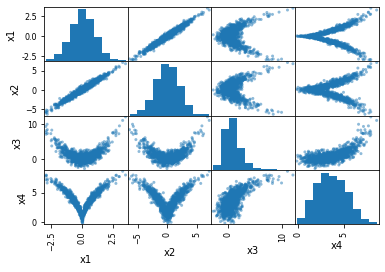

In [13]:
_ = pd.plotting.scatter_matrix(df)

In [14]:
ce_pca = PCA()
ce_pca.fit(df)

ce_ipca = CategoricalEmbedding()
ce_ipca.fit(df)

The eigenvalues are not equal, also not equal up to a scaling factor

In [15]:
ce_ipca._eig_vals / ce_pca._eig_vals

array([6.32623482, 0.22624278, 0.22624278, 6.32623482])

In [16]:
y_pca = ce_pca.transform(df).iloc[:, ::-1]
y_ipca = ce_ipca.transform(df)

In [17]:
y_pca.values[0] / y_ipca.values[0]

array([-1., -1., -1.,  1.])

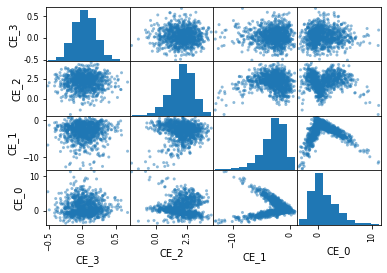

In [18]:
_ = pd.plotting.scatter_matrix(y_pca)

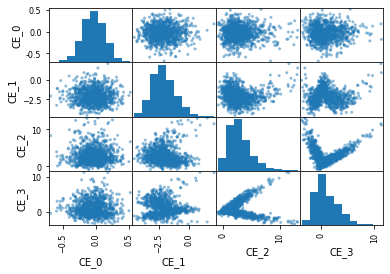

In [19]:
_ = pd.plotting.scatter_matrix(y_ipca)

### Functions for plotting

In [20]:
def rand_jitter(arr):
    stdev = max(0.001, .01*(max(arr)-min(arr)))
    return arr + np.random.randn(len(arr)) * stdev

def scatter_plot(x, y, col, jitter=True):
    
    if jitter:
        x = rand_jitter(x)
        y = rand_jitter(y)
    
    uniq = list(set(col))

    # Set the color map to match the number of species
    hot = plt.get_cmap('hot')
    cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    for i, cat in enumerate(uniq):

        idx = col == cat

        plt.scatter(x[idx], y[idx], 
                    color=scalarMap.to_rgba(i), 
                    label=cat)
        
    # plt.legend(loc='upper left')
    # Put a legend to the right of the current axis
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [21]:
n = 500
n_col = 5

X = np.append(np.repeat(1, n-1), 0)

for _ in range(n_col-1):
    p = np.random.rand()
    x1 = np.random.choice([0, 1], size=n, p=[p, 1-p])


    X = np.c_[X, x1]

In [22]:
sppca = CategoricalEmbedding()
sp_pcs = sppca.fit_transform(X)

pca = PCA()
nr_pcs = pca.fit_transform(X)

sp_pcs, nr_pcs = flip_signs(sp_pcs, nr_pcs)

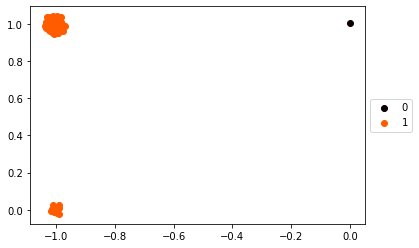

In [27]:
scatter_plot(x = sp_pcs.iloc[:,0], 
             y = sp_pcs.iloc[:,1], 
             col = X[:, 0], 
             jitter=True)

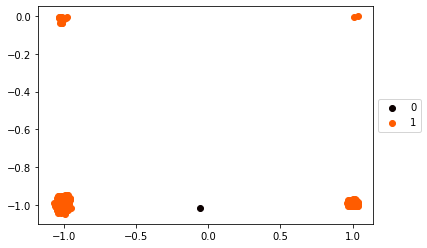

In [28]:
scatter_plot(x = nr_pcs.iloc[:, -1], 
             y = nr_pcs.iloc[:, -2], 
             col = X[:, 0], 
             jitter=True)

### Experiment 1: what dimensions are captured by the first PCs?

hypothesis: sspca will focus on the categories that occur least often

It is not about the relative proportion of categories within a column. Because the categories are binary encoded, only the counts matter. Therefore the number of categories within a class is also not important IF we condition on the counts.  

In [29]:
def generate_tx(anomaly_fields=None):
    
    tx = {
        'method': np.random.choice(['iDeal', 'bank_transfer', 'credit_card'], p=[0.4, 0.3, 0.3]),
        'sender_country': np.random.choice(['NL', 'DE', 'US'], p=[0.8, 0.15, 0.05]),
        'receiver_country': np.random.choice(['NL', 'DE', 'US'], p=[0.8, 0.15, 0.05]),
        'currency': np.random.choice(['EUR', 'USD', 'GBP'], p=[0.33, 0.33, 0.34]), 
        'class': 'normal'
    }
    
    if anomaly_fields:
        
        tx['class'] = 'anomaly'
        
        if 'method' in anomaly_fields:
            tx['method'] = np.random.choice(['iDeal', 'klarna', 'mr_cash'], p=[0.6, 0.2, 0.2])
            
        if 'sender_country' in anomaly_fields:
            tx['sender_country'] = np.random.choice(['GI', 'AF'], p=[0.7, 0.3])
            
        if 'receiver_country' in anomaly_fields:
            tx['receiver_country'] = np.random.choice(['GI', 'AF'], p=[0.5, 0.5])
            
        if 'currency' in anomaly_fields:
            tx['currency'] = np.random.choice(['AFN', 'DZD'], p=[0.5, 0.5])
        
    return tx

fields = ['method', 'sender_country', 'receiver_country', 'currency']

In [30]:
n = 500
p = 0.1

rows = []

for _ in range(n): 
    
    anomaly_fields = []
    while np.random.choice([True, False], p=[p, 1-p]):
        anomaly_fields.append(np.random.choice(fields))
        
    tx = generate_tx(anomaly_fields)
    rows.append(tx)
    
df = pd.DataFrame(rows)

In [31]:
df_cat = df.drop(columns='class')
df_dum = pd.get_dummies(df_cat)
#df_dum['empty']=0

In [32]:
sppca = CategoricalEmbedding()
bsd = BlackSwanDetector()
df_dum, df_dum_bs = bsd.fit_transform(df_dum)
pcs = sppca.fit_transform(df_dum)

/Users/bartlammers/Documents/experiments/categorical_embedding/src/categorical.py:193: UserWarning: 16 components zero variance! Does this make sense?!
  warnings.warn(message)


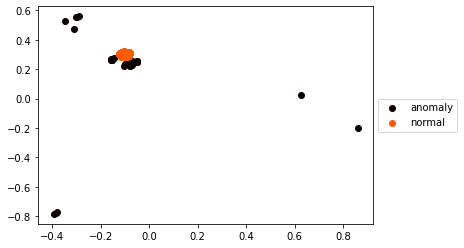

In [37]:
scatter_plot(x = pcs.iloc[:,0], 
             y = pcs.iloc[:,1],
             col = df['class'], 
             jitter=False)

In [38]:
positive_counts = df_dum.apply(lambda x: sum(x))
positive_counts.sort_values()

method_mr_cash            2
method_klarna             3
currency_DZD              5
sender_country_GI         6
sender_country_AF         7
currency_AFN              9
receiver_country_GI      10
receiver_country_AF      10
sender_country_US        29
receiver_country_US      30
receiver_country_DE      67
sender_country_DE        76
method_bank_transfer    144
method_credit_card      146
currency_GBP            148
currency_USD            161
currency_EUR            177
method_iDeal            205
sender_country_NL       382
receiver_country_NL     383
dtype: int64

### Experiment 2: what dimensions are captured without any anomalies?

Hypothesis: the dimensions with the smallest variance --> very unbalanced classes

* method: balanced
* sender_country: unbalanced --> US smallest category
* receiver_country: unbalanced --> US smallest category
* currency: balanced


In [39]:
n = 500

rows = []

for _ in range(n): 
    
    anomaly_fields = []        
    tx = generate_tx(anomaly_fields)
    rows.append(tx)
    
df_clean = pd.DataFrame(rows)

In [40]:
df_cat_clean = df_clean.drop(columns='class')
df_dum_clean = pd.get_dummies(df_cat_clean)

In [41]:
sppca_clean = CategoricalEmbedding()
pcs_clean = sppca_clean.fit_transform(df_dum_clean)

/Users/bartlammers/Documents/experiments/categorical_embedding/src/categorical.py:193: UserWarning: 8 components zero variance! Does this make sense?!
  warnings.warn(message)


In [42]:
# Calculate components
components = super().transform(X, None)

RuntimeError: super(): no arguments

In [43]:
# Which components have a variance larger than the threshold
components_mask = np.diag(np.cov(components.T)) > 1e-18

NameError: name 'components' is not defined

Focus is indeed on the US

In [ ]:
scatter_plot(x = pcs_clean[:,0], 
             y = pcs_clean[:,1], 
             col = df_clean['receiver_country'], jitter=False)

### Experiment 3: what happens when a category is not present in train set?

Hypothesis: if a category is not present in the training set the sspca will not focus on this dimension

In [ ]:
n = 500

rows = []

for _ in range(n): 
    
    anomaly_fields = []        
    tx = generate_tx(anomaly_fields)
    rows.append(tx)
    
df_clean = pd.DataFrame(rows)

In [ ]:
df_cat_clean = df_clean.drop(columns='class')
df_dum_clean = pd.get_dummies(df_cat_clean)
df_dum_clean['black_swan'] = 0

In [ ]:
sppca_clean = SparsityPreservingPCA(black_swan_protection=False)
pcs_clean = sppca_clean.fit_transform(df_dum_clean)
pcs_clean.shape

In [ ]:
scatter_plot(x = pcs_clean[:,0], 
             y = pcs_clean[:,1], 
             col = df_dum_clean['black_swan'])

In [ ]:
df_dum_contam = df_dum_clean.copy()
df_dum_contam.loc[0, 'black_swan']=1

In [ ]:
pcs_contam = sppca_clean.transform(df_dum_contam)

The anomaly is indeed not distinguishable in the first pcs. Around PC10 the anomaly becomes visible.

In [ ]:
scatter_plot(x = pcs_contam[:,0], 
             y = pcs_contam[:,1], 
             col = df_dum_contam['black_swan'])

### Experiment 4: remedy for black swan events

Hypothesis: if we append a row with all zeros and a row with all ones to the dummie df, black swan events can be captured

Implemented in SparsityPreservingPCA class --> argument black_swan_protection=True

In [ ]:
n = 500

rows = []

for _ in range(n): 
    
    anomaly_fields = []        
    tx = generate_tx(anomaly_fields)
    rows.append(tx)
    
df_clean = pd.DataFrame(rows)

In [ ]:
df_cat_clean = df_clean.drop(columns='class')
df_dum_clean = pd.get_dummies(df_cat_clean)
df_dum_clean['black_swan1'] = 0
df_dum_clean['black_swan2'] = 0

In [ ]:
sppca_clean = SparsityPreservingPCA(black_swan_protection=True)
pcs_clean = sppca_clean.fit_transform(df_dum_clean)

In [ ]:
scatter_plot(x = pcs_clean[:,0], 
             y = pcs_clean[:,1],
             col = df_clean['method'], jitter=False) #df_dum_clean['black_swan1'])

In [ ]:
positive_counts = df_dum_clean.apply(lambda x: sum(x))
positive_counts.sort_values()

In [ ]:
df_dum_contam = df_dum_clean.copy()
df_dum_contam.loc[0, 'black_swan1']=1
df_dum_contam.loc[0, 'black_swan2']=0

In [ ]:
pcs_contam = sppca_clean.transform(df_dum_contam)

The anomaly is now detected in the dimensions, this is the black swan column

In [ ]:
scatter_plot(x = pcs_contam[:,0], 
             y = pcs_contam[:,1], 
             col = df_dum_contam['black_swan1'])

In [ ]:
scatter_plot(x = pcs_clean[:,2], 
             y = pcs_clean[:,1], 
             col = df_clean['receiver_country'])